In [96]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

In [97]:
df = pd.read_csv("mcdonalds.csv")

In [98]:
df.head()

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Age,VisitFrequency,Gender
0,No,Yes,No,Yes,No,Yes,Yes,No,Yes,No,No,-3,61,Every three months,Female
1,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,+2,51,Every three months,Female
2,No,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,+1,62,Every three months,Female
3,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,No,No,Yes,+4,69,Once a week,Female
4,No,Yes,No,Yes,Yes,Yes,Yes,No,No,Yes,No,+2,49,Once a month,Male


In [99]:
#Convert Yes/No to binary (1/0) for k-means
MD = df.iloc[:, :11].apply(lambda col: col.map(lambda x: 1 if x == 'Yes' else 0))
MD.head()

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting
0,0,1,0,1,0,1,1,0,1,0,0
1,1,1,0,1,1,1,1,1,1,0,0
2,0,1,1,1,1,1,0,1,1,1,0
3,1,1,0,1,1,1,1,1,0,0,1
4,0,1,0,1,1,1,1,0,0,1,0


MD_km28[k] --------->  KMeans(n_clusters=2, n_init=10, random_state=1234)
MD_km28[k] --------->  KMeans(n_clusters=3, n_init=10, random_state=1234)
MD_km28[k] --------->  KMeans(n_clusters=4, n_init=10, random_state=1234)
MD_km28[k] --------->  KMeans(n_clusters=5, n_init=10, random_state=1234)
MD_km28[k] --------->  KMeans(n_clusters=6, n_init=10, random_state=1234)
MD_km28[k] --------->  KMeans(n_clusters=7, n_init=10, random_state=1234)
MD_km28[k] --------->  KMeans(n_init=10, random_state=1234)
[2145.5037269171585, 1819.7485024199, 1602.9860148663229, 1435.3247856933979, 1332.150483061454, 1249.2338900799612, 1191.5809481928047]


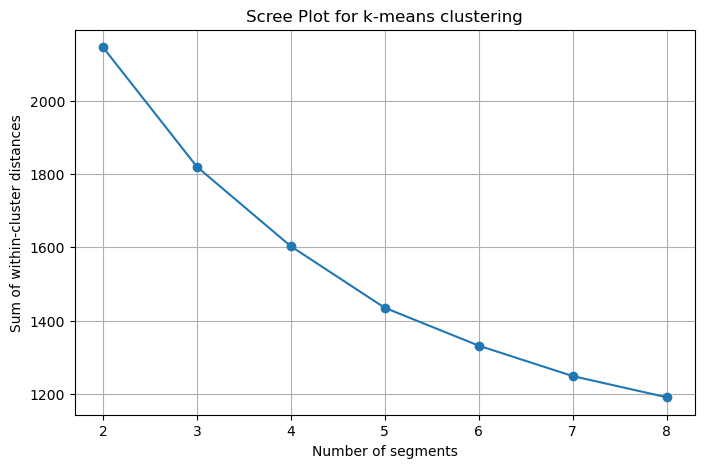

In [100]:
#Set random seed for reproducibility
np.random.seed(1234)
# Run k-means for clusters 2 to 8 with 10 random initializations
MD_km28 = {}
#inertias are within cluster distance
inertias = []

for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=1234)
    kmeans.fit(MD)
    MD_km28[k] = kmeans
    print("MD_km28[k] ---------> ",MD_km28[k])
    inertias.append(kmeans.inertia_)
print(inertias)

# Plot scree plot (within-cluster sum of squares vs number of segments)
plt.figure(figsize=(8, 5))
plt.plot(range(2, 9), inertias, marker='o')
plt.xlabel("Number of segments")
plt.ylabel("Sum of within-cluster distances")
plt.title("Scree Plot for k-means clustering")
plt.grid(True)
plt.show()

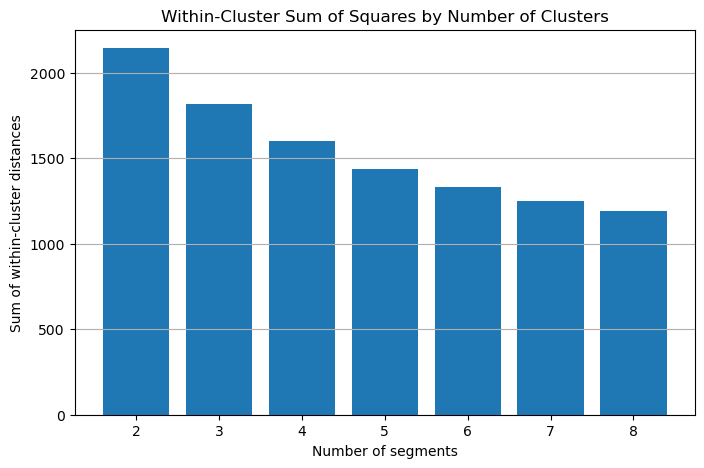

In [101]:
plt.figure(figsize=(8, 5))
plt.bar(range(2, 9), inertias)
plt.xlabel("Number of segments")
plt.ylabel("Sum of within-cluster distances")
plt.title("Within-Cluster Sum of Squares by Number of Clusters")
plt.grid(True, axis='y')
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:47<00:00, 23.86s/it]


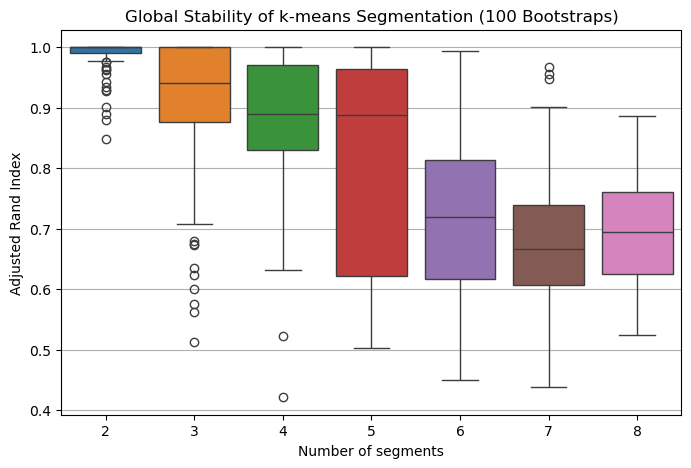

In [102]:
from sklearn.metrics import adjusted_rand_score
from sklearn.utils import resample
from tqdm import tqdm

np.random.seed(1234)

# Number of bootstrap samples
nboot = 100
# Number of random initializations (n_init in KMeans)
nrep = 10

# Dictionary to store stability scores for each k
stability_scores = {k: [] for k in range(2, 9)}

# Computing stability via bootstrapping
for k in tqdm(range(2, 9)):  # For k = 2 to 8
    for _ in range(nboot):  # Number of bootstrap samples
        sample = resample(MD, replace=True, random_state=np.random.randint(0, 10000))
        
        model1 = KMeans(n_clusters=k, n_init=nrep, random_state=np.random.randint(0, 10000))
        model1.fit(sample)
        
        model2 = KMeans(n_clusters=k, n_init=nrep, random_state=np.random.randint(0, 10000))
        model2.fit(sample)
        
        # Comparing the two clusterings using Adjusted Rand Index
        ari = adjusted_rand_score(model1.labels_, model2.labels_)
        stability_scores[k].append(ari)

# Converting to DataFrame for easier plotting
stability_df = pd.DataFrame(stability_scores)

# global stability boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(data=stability_df)
plt.xticks(ticks=range(0, 7), labels=range(2, 9))
plt.xlabel("Number of segments")
plt.ylabel("Adjusted Rand Index")
plt.title("Global Stability of k-means Segmentation (100 Bootstraps)")
plt.grid(True, axis='y')
plt.show()

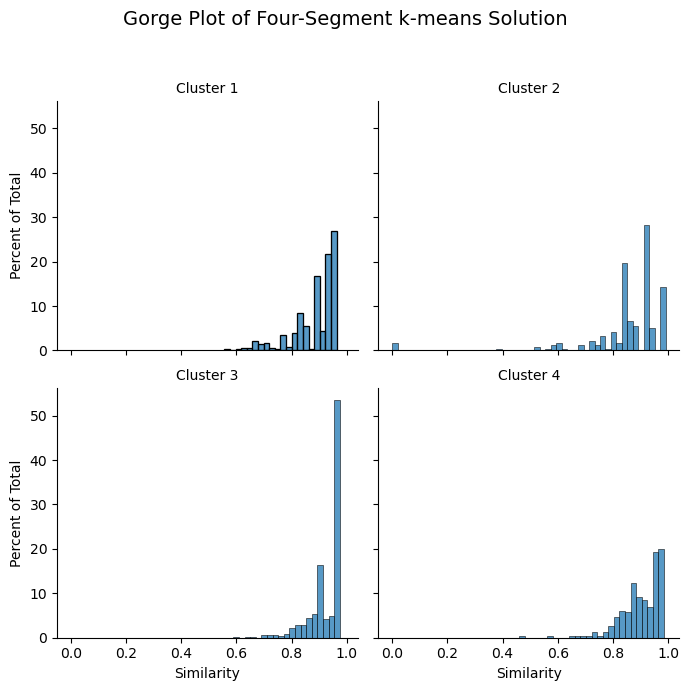

In [116]:
from sklearn.metrics.pairwise import cosine_similarity  # Import cosine similarity for calculating how similar data points are to their cluster centroids

k = 4  # We decided to segment the data into 4 clusters

# Perform KMeans clustering
kmeans = KMeans(n_clusters=k, n_init=10, random_state=1234)  # Initialize KMeans with 4 clusters and random seed for reproducibility
labels = kmeans.fit_predict(MD)
centroids = kmeans.cluster_centers_  # Get the center (centroid) of each cluster, which represents the mean of the data points in that cluster

# Calculate cosine similarity between each data point and its assigned cluster centroid
similarities = []  # Prepare an empty list to store the similarity values for each data point
for i, row in MD.iterrows():  # Loop through each data point in the dataset
    label = labels[i]  # Get the cluster label for the current data point
    # Calculate the cosine similarity between the current data point and the centroid of the assigned cluster
    sim = cosine_similarity([row], [centroids[label]])[0][0]
    similarities.append((label, sim))  # Store the similarity and the cluster label for each data point

# Create a DataFrame to store the similarities for each data point
sim_df = pd.DataFrame(similarities, columns=['Cluster', 'Similarity'])  
sim_df['Cluster'] = sim_df['Cluster'] + 1  # Optional: Adjust cluster labels to start from 1 for better readability (since KMeans starts from 0)

# Step 4: Visualize the similarity distributions for each cluster using histograms
g = sns.FacetGrid(sim_df, col="Cluster", col_wrap=2, height=3.5, sharex=True, sharey=True)
g.map_dataframe(sns.histplot, x="Similarity", stat="percent", binwidth=0.02, edgecolor="black")  # Plot histograms showing the similarity distribution for each cluster
g.set_axis_labels("Similarity", "Percent of Total") 
g.set_titles("Cluster {col_name}")  
plt.subplots_adjust(top=0.85)  
g.fig.suptitle("Gorge Plot of Four-Segment k-means Solution", fontsize=14) 
plt.show()  # Display the plot


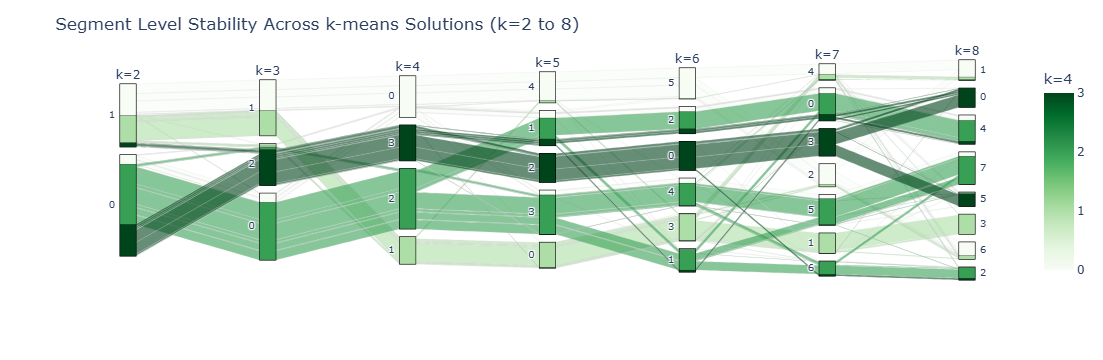

In [118]:
from sklearn.preprocessing import LabelEncoder  
import plotly.express as px  # Importing Plotly for interactive visualizations

# Perform KMeans clustering for k=2 to k=8 and store the cluster labels
cluster_assignments = {
    f'k={k}': KMeans(n_clusters=k, n_init=10, random_state=1234).fit_predict(MD) 
    for k in range(2, 9)  # Perform clustering for k values from 2 to 8
}

# Convert cluster assignments to a DataFrame for easier handling and visualization
cluster_df = pd.DataFrame(cluster_assignments, index=MD.index) 

# Label encoding the cluster labels to numeric values for better visualization
le = LabelEncoder()  
for col in cluster_df.columns:  # Iterate over each column (which represents a clustering solution for a different k)
    cluster_df[col] = le.fit_transform(cluster_df[col])  # Apply encoding to each column

# Create a parallel categories plot to visualize the stability of clusters across different k-values
fig = px.parallel_categories(
    cluster_df,  # DataFrame containing cluster assignments for different k values
    dimensions=cluster_df.columns,  # Dimensions to plot (cluster assignments for each k)
    color=cluster_df['k=4'],  # Highlight clusters from the k=4 solution by coloring them
    color_continuous_scale='Greens',  # Set color scale to a gradient of green
    labels={col: col for col in cluster_df.columns}  # Labels for each dimension (k values)
)

fig.update_layout(title="Segment Level Stability Across k-means Solutions (k=2 to 8)")
fig.show()  # Display the plot


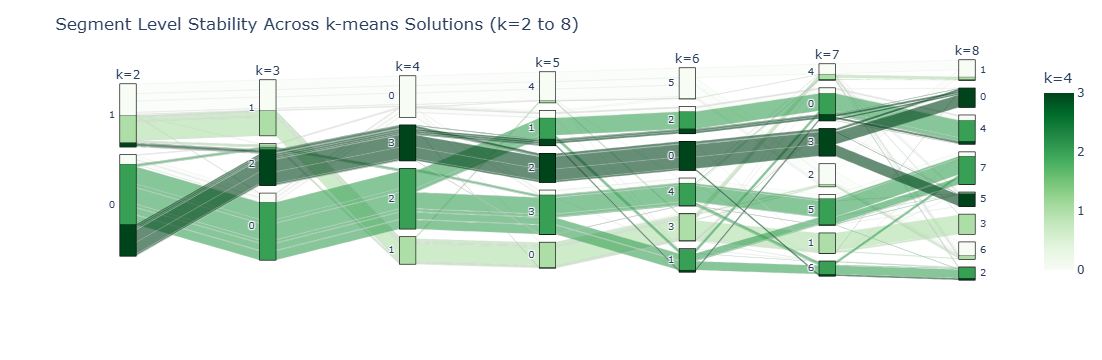

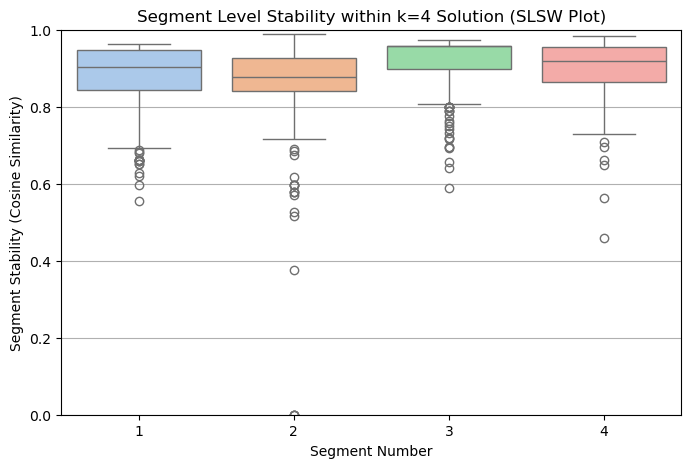

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.boxplot(data=sim_df, x='Cluster', y='Similarity', palette="pastel")
plt.xlabel("Segment Number")
plt.ylabel("Segment Stability (Cosine Similarity)")
plt.title("Segment Level Stability within k=4 Solution (SLSW Plot)")
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.show()

In [106]:
# Import the 'entropy' function from the 'scipy.stats' module.
# The 'entropy' function is used to calculate the entropy of a probability distribution.
from scipy.stats import entropy

# Set a seed value to make the random number generation reproducible.
# This ensures that the same random numbers are generated every time the code is run with the same seed.
np.random.seed(1234)

# Define the range of the number of clusters to test (from 2 to 8, excluding 9).
k_values = range(2, 9)

# Create an empty list to store the results for different numbers of clusters.
# The results include various clustering evaluation metrics for each number of clusters.
MD_m28 = []

# Iterate over each number of clusters (2 to 8) to perform KMeans clustering and calculate evaluation metrics.
for k in k_values:
    # Create a KMeans model with 'k' clusters and a fixed random seed for reproducibility.
    model = KMeans(n_clusters=k, random_state=1234)

    # Fit the KMeans model on the original data 'MD'.
    model.fit(MD.values)

    # Get the number of iterations required for the model to converge.
    iter_val = model.n_iter_

    # Check if the model has converged (reached a stable solution).
    # In the KMeans algorithm, convergence means that the cluster assignments do not change in consecutive iterations.
    converged = True

    # Store the current number of clusters ('k') and an extra variable 'k0_val'.
    # The purpose of 'k0_val' is not explicitly clear in the code.
    k_val = k
    k0_val = k

    # Calculate the log-likelihood of the data under the clustering model.
    log_likelihood = -model.inertia_

    # Get the number of samples (data points) and features in the 'MD' DataFrame.
    n_samples, _ = MD.shape

    # Calculate the Akaike Information Criterion (AIC) for model evaluation.
    aic = -2 * log_likelihood + 2 * k

    # Calculate the Bayesian Information Criterion (BIC) for model evaluation.
    # The BIC penalizes complex models by taking into account both the likelihood and the number of parameters (k).
    bic = -2 * log_likelihood + np.log(n_samples) * k

    # Get the cluster labels for the data points based on the clustering model.
    labels = model.labels_

    # Calculate the proportion of data points in each cluster and store it as 'probs'.
    counts = np.bincount(labels)
    probs = counts / float(counts.sum())

    # Calculate the entropy of the cluster assignments to measure cluster purity.
    class_entropy = entropy(probs)

    # Calculate the Integrated Complete Likelihood (ICL) for model selection.
    # The ICL is obtained by subtracting the class entropy from the BIC.
    icl = bic - class_entropy

    # Append the evaluation metrics for the current number of clusters to the 'MD_m28' list.
    MD_m28.append((iter_val, converged, k_val, k0_val, log_likelihood, aic, bic, icl))

# Convert the list of evaluation metrics into a pandas DataFrame for easy tabular representation.
MD_m28 = pd.DataFrame(MD_m28, columns=['iter', 'converged', 'k', 'k0', 'logLik', 'AIC', 'BIC', 'ICL'])

# Print the DataFrame containing the evaluation metrics for different numbers of clusters.
print(MD_m28)

   iter  converged  k  k0       logLik          AIC          BIC          ICL
0    13       True  2   2 -2146.062044  4296.124088  4306.686859  4306.015908
1     5       True  3   3 -1896.330266  3798.660532  3814.504689  3813.529671
2     8       True  4   4 -1604.234391  3216.468783  3237.594326  3236.258023
3     9       True  5   5 -1502.697153  3015.394306  3041.801234  3040.267284
4     7       True  6   6 -1348.665399  2709.330799  2741.019113  2739.277954
5    10       True  7   7 -1249.233890  2512.467780  2549.437480  2547.530062
6     9       True  8   8 -1203.646165  2423.292330  2465.543415  2463.533662


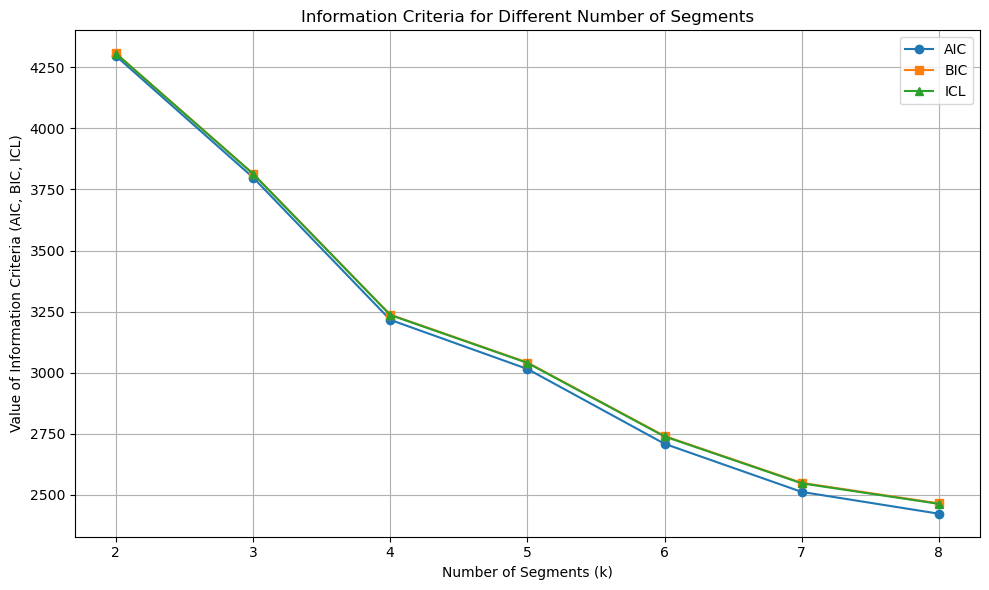

In [107]:

import matplotlib.pyplot as plt

# Assuming MD_m28 is your DataFrame with the computed metrics
plt.figure(figsize=(10, 6))
plt.plot(MD_m28['k'], MD_m28['AIC'], marker='o', label='AIC')
plt.plot(MD_m28['k'], MD_m28['BIC'], marker='s', label='BIC')
plt.plot(MD_m28['k'], MD_m28['ICL'], marker='^', label='ICL')

plt.xlabel('Number of Segments (k)')
plt.ylabel('Value of Information Criteria (AIC, BIC, ICL)')
plt.title('Information Criteria for Different Number of Segments')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [108]:
like_mapping = {
    'I hate it!-5': -5,
    '-4': -4,
    '-3': -3,
    '-2': -2,
    '-1': -1,
    '0': 0,
    '+1': 1,
    '+2': 2,
    '+3': 3,
    '+4': 4,
    'I love it!+5': 5
}

df['Like.n'] = df['Like'].map(like_mapping)

like_n_counts = df['Like.n'].value_counts()

print(like_n_counts)

Like.n
 3    229
 2    187
 0    169
 4    160
 1    152
-5    152
 5    143
-3     73
-4     71
-2     59
-1     58
Name: count, dtype: int64


In [109]:
from patsy import dmatrices

# List of independent variables (assuming these are the column names)
independent_vars = ['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 
                    'fast', 'cheap', 'tasty', 'expensive', 'healthy', 'disgusting']

# Creating the formula by joining the independent variable names with a plus sign
formula = 'Like ~ ' + ' + '.join(independent_vars)

# Print the formula
print(formula)

f = dmatrices(formula, data=df)[1]


Like ~ yummy + convenient + spicy + fattening + greasy + fast + cheap + tasty + expensive + healthy + disgusting


In [119]:
from patsy import dmatrix
X = dmatrix(f.design_info, data=df)
y = dmatrix('Like', data=df)

n_components = 2
n_init = 10
verbose = False
n_rep = 10

model = GaussianMixture(n_components=n_components, n_init=n_init, verbose=verbose)

MD_reg2 = model.fit(X, y)

print(MD_reg2)

cluster_sizes = np.bincount(model.predict(X))

print("Cluster sizes:")
for i, size in enumerate(cluster_sizes):
    print(f"{i+1}: {size}")

from patsy import dmatrix  # Importing dmatrix from Patsy to create design matrices for regression models

# Create design matrices for the independent variables (X) and dependent variable (y)
X = dmatrix(f.design_info, data=df)  # Create design matrix X using the formula's design info (features in df)
y = dmatrix('Like', data=df)  # Create design matrix y for the dependent variable 'Like' from df

# Set parameters for the Gaussian Mixture Model (GMM)
n_components = 2  # Number of components (clusters) in the Gaussian Mixture Model (GMM)
n_init = 10  # Number of initializations to avoid local minima during fitting
verbose = False  # Whether to print detailed progress of the algorithm (set to False for no output)
n_rep = 10  # Number of repetitions (not used directly here but often useful for robustness)

# Initialize and fit the Gaussian Mixture Model
model = GaussianMixture(n_components=n_components, n_init=n_init, verbose=verbose)  
MD_reg2 = model.fit(X, y)  

# Print the results of the fitted GMM model
print(MD_reg2)  

# Calculate the cluster sizes (number of data points assigned to each cluster)
cluster_sizes = np.bincount(model.predict(X))  # Predict the cluster for each data point and count the occurrences (cluster sizes)

# Print the cluster sizes to see how many points belong to each cluster
print("Cluster sizes:")  
for i, size in enumerate(cluster_sizes):  # Iterate over each cluster size and print it
    print(f"{i+1}: {size}")  # Print cluster index (i+1) and the corresponding size


GaussianMixture(n_components=2, n_init=10, verbose=False)
Cluster sizes:
1: 985
2: 468
GaussianMixture(n_components=2, n_init=10, verbose=False)
Cluster sizes:
1: 468
2: 985


In [111]:
def age_category(age):
    if age >= 18 and age <= 35:
        return 'Young'
    elif age >= 36 and age <= 55:
        return 'Adult'
    else:
        return 'Old'

df['Age_Segment'] = df['Age'].apply(age_category)

print(df[['Age', 'Age_Segment']].head())
df.Age_Segment.sample(10)

   Age Age_Segment
0   61         Old
1   51       Adult
2   62         Old
3   69         Old
4   49       Adult


466       Old
631     Young
1445    Young
1173      Old
458     Young
623     Young
1265    Adult
1294    Adult
411     Young
181     Young
Name: Age_Segment, dtype: object

In [114]:
# Filtering the dataframe to find segments with high 'yummy' and 'tasty', but low 'cheap' and 'expensive'
segment = (MD['yummy'] >= 1) & (MD['tasty'] >= 1) & (MD['cheap'] == 0) & (MD['expensive'] == 0)
MD[segment][['yummy','tasty','cheap','expensive']].head()

,yummy,tasty,cheap,expensive
17,1,1,0,0
43,1,1,0,0
60,1,1,0,0
95,1,1,0,0
104,1,1,0,0
